In [159]:
import glob
d_path = sorted(glob.glob('/Users/ste/code/active_learning/history/*'))[-1]
d_path

'/Users/ste/code/active_learning/history/final'

In [5]:
import os
dataset_path = os.path.join(d_path, 'train.pkl')
dataset_path

'/Users/ste/code/active_learning/history/1231-002801/train.pkl'

## Lab

In [6]:
import pandas as pd
df = pd.read_pickle(dataset_path)

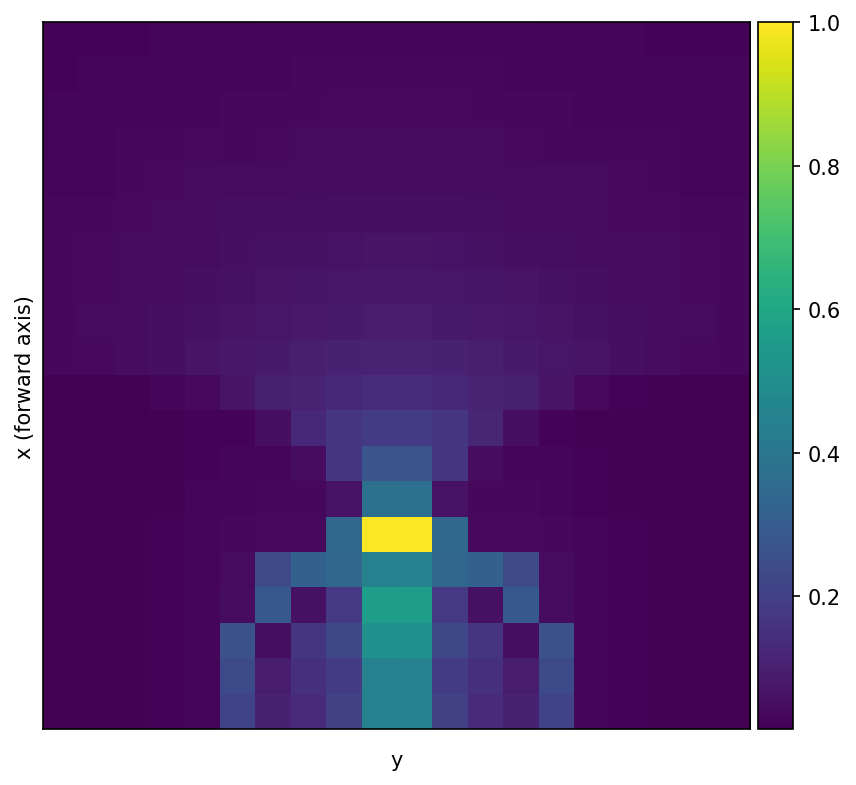

In [158]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
def compute_map_density(df, title=None):
    a = np.array([np.flip(np.array(x).reshape(20,20),axis=1).flatten() if random.random() > 0.5 else np.array(x) for x in df['target_map'].values])
    a[a == 0] = 1
    a[a == -1] = 0
    b = a.sum(axis=0) / a.shape[0]
    fig, ax = plt.subplots(figsize=(5,5),dpi=150)
    #ax = sns.heatmap(data=b.reshape(20,20), cbar=True)
    im = ax.imshow(b.reshape(20,20))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, ax=ax, cax=cax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('x (forward axis)')
    ax.set_xlabel('y', rotation=0, labelpad=10)
    ax.set_aspect('equal')
    if title is not None:
        ax.set_title(title)
    plt.subplots_adjust(0,0,1,1)
    plt.savefig(os.path.join(d_path,'cell_frequency.png'))
    plt.show()
compute_map_density(df, title='')

In [114]:
model_folder = sorted(glob.glob('/Volumes/home/experiments/0*'))[-1]
model_folder

'/Volumes/home/experiments/0101-1959_yellow-hippo_b10'

In [115]:
import os
#weights_path = os.path.join(glob.glob('/Volumes/home/experiments/*green-gnu_b10/')[0],'checkpoint.pt')
#weights_path = os.path.join(glob.glob('/Volumes/home/experiments/*green-snake/')[0],'checkpoint.pt')
#weights_path = os.path.join(glob.glob('/Users/ste/Desktop/experiments/*green-snake*/')[0],'checkpoint.pt')

weights_path = os.path.join(model_folder,'checkpoint.pt')
assert os.path.exists(weights_path)
weights_path

'/Volumes/home/experiments/0101-1959_yellow-hippo_b10/checkpoint.pt'

In [116]:
import sys
from pathlib import Path
path = str(Path(os.path.join('..','src','elohim','elohim')).resolve())
if path not in sys.path:
    sys.path.insert(0,path)

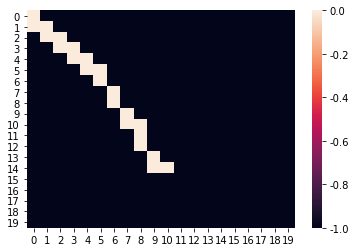

In [117]:
df2 = df.iloc[:2000]
import dataset_ml, importlib
importlib.reload(dataset_ml)
import random
random.seed(0)
from dataset_ml import ConvDataset, transform_function

cd = ConvDataset(df2['image'], labels=df2['target_map'], transform=transform_function(resize=True))

from torch.utils.data import DataLoader
loader = DataLoader(cd, batch_size=4, shuffle=False)
X, y = next(iter(loader))
sns.heatmap(data=y[0].reshape(20,20))

In [118]:
import json
import numpy as np
points_file = os.path.join(d_path, 'points.json')
with open(points_file) as f:
    points = json.load(f)
targets = np.array([[t["x"], t["y"]] for t in points["targets"]])
spawn_coords = np.array([[t["x"], t["y"]] for t in points["spawn_coords"]])

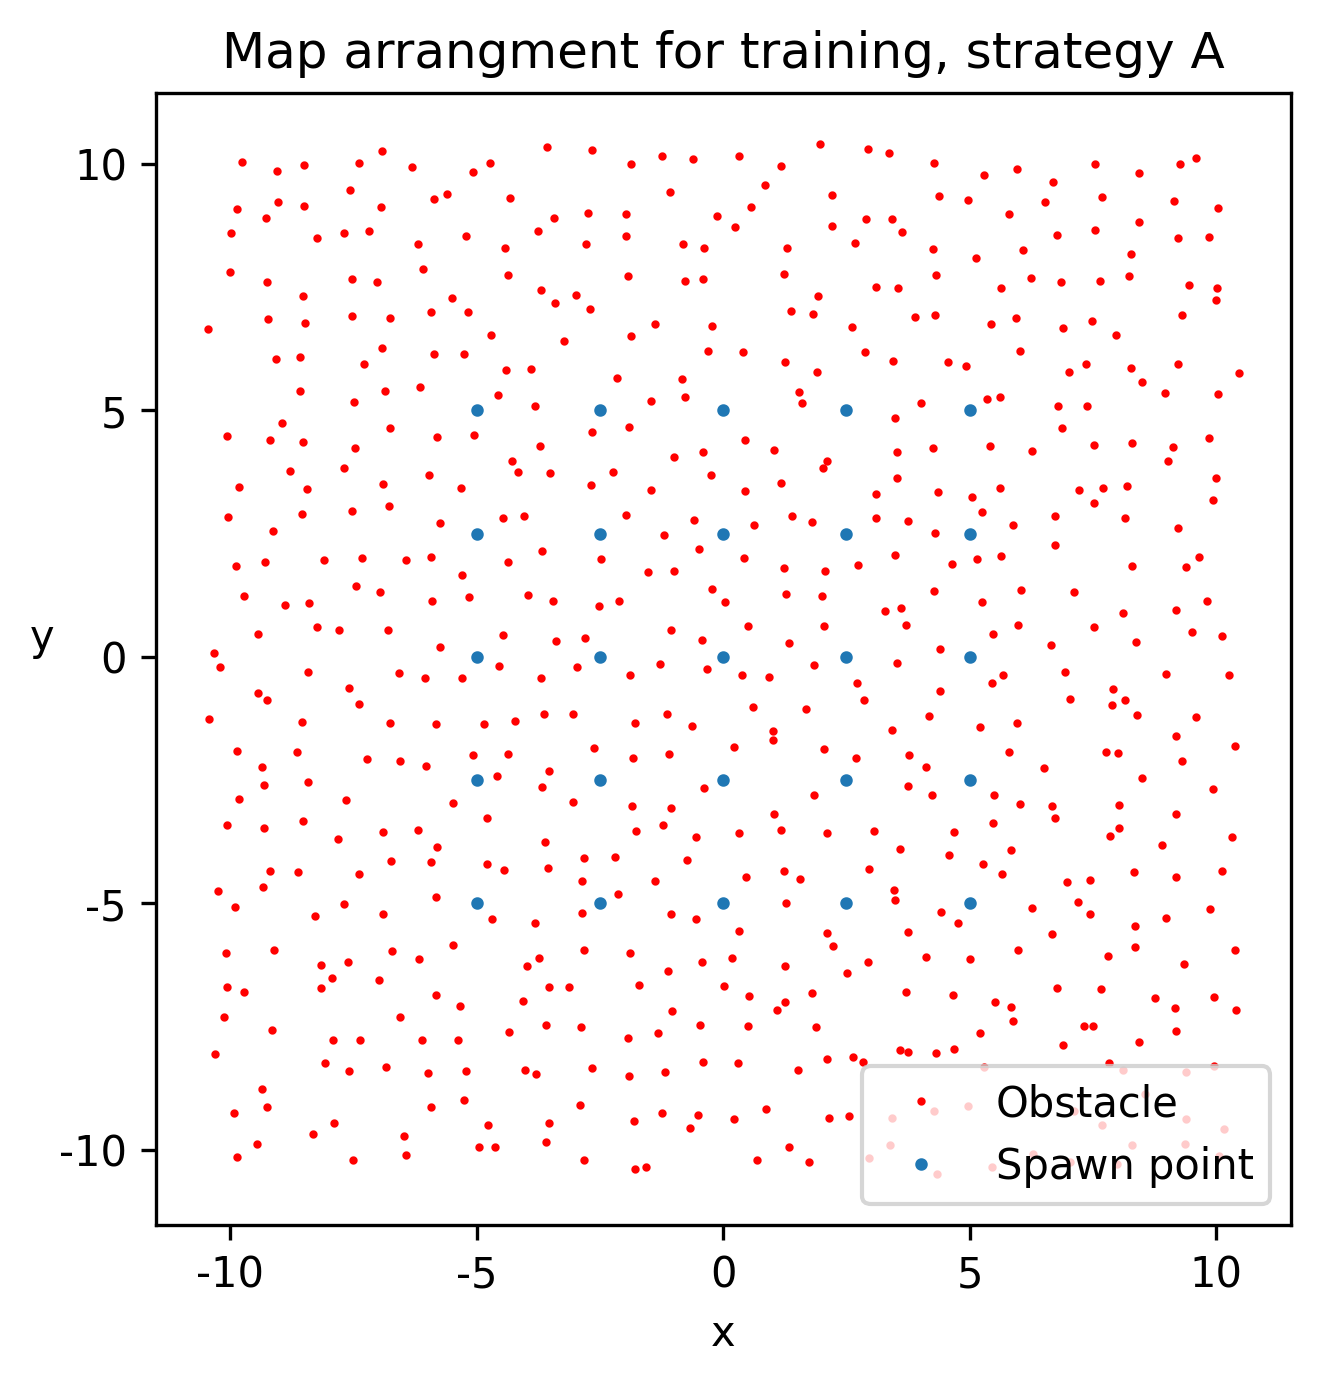

In [119]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5),dpi=300)
ax.plot(*targets.T, 'o', c='red',ms=1, label='Obstacle')
ax.plot(*spawn_coords.T, 'o', ms=2, label='Spawn point')
ax.set_xlabel('x')
ax.set_ylabel('y',rotation=0)
ax.set_aspect('equal')
ax.legend()
ax.set_title('Map arrangment for training, strategy A');
plt.savefig('training_map_1.png')

In [120]:
!pwd

/Users/ste/code/active_learning/notebooks


In [121]:
import torch
device = 'cpu'
w = torch.load(weights_path, map_location=torch.device(device))

In [138]:
import torch
import sys, pathlib, importlib
path = str(pathlib.Path(os.path.join('..','src','elohim','elohim')).resolve())
if path not in sys.path:
    sys.path.insert(0,path)
import model
importlib.reload(model)
from model import ConvNet, BayesConvNet

In [145]:
parallel = False
bayes = True
device = 'cpu'

In [146]:
common_parameters = {'num_classes': 400, 'mode': 'softmax'}
if bayes:
    irs = [[1, 16, 1, 1],
           [6, 24, 2, 2],
           [6, 32, 3, 2],
           [6, 64, 4, 2]]
    model = BayesConvNet(inverted_residual_setting=irs, **common_parameters, samples=10)
else:
    irs = [[1, 16, 1, 1],
           [6, 24, 2, 2],
           [6, 32, 3, 2],
           [6, 64, 2, 2],
           [6, 96, 1, 1]]
    model = ConvNet(inverted_residual_setting=irs,**common_parameters)
device = 'cpu'

if parallel:
    model = torch.nn.DataParallel(model)

weights = torch.load(weights_path, map_location=torch.device(device))



This bayesian network will sample 10 times


In [147]:
weights = {k.replace('module.',''):v for k,v in weights.items()}

In [148]:
model.load_state_dict(weights)

<All keys matched successfully>

In [130]:
w = torch.load(weights_path, map_location=torch.device(device))

In [131]:
len(w.keys()), len(model.state_dict())

(190, 190)

In [133]:
ws = [w.keys(), model.state_dict()]
for a,b in zip(*ws):
    if a != b:
        print(f'{a:<50}{b:<50}')
m = np.argmax([len(x) for x in ws])
print()
for a in list(ws[m])[len(ws[1-m]):]:
    print(f'{a:<50}')

features.0.0.weight                               module.features.0.0.weight                        
features.0.1.weight                               module.features.0.1.weight                        
features.0.1.bias                                 module.features.0.1.bias                          
features.0.1.running_mean                         module.features.0.1.running_mean                  
features.0.1.running_var                          module.features.0.1.running_var                   
features.0.1.num_batches_tracked                  module.features.0.1.num_batches_tracked           
features.1.conv.0.0.weight                        module.features.1.conv.0.0.weight                 
features.1.conv.0.1.weight                        module.features.1.conv.0.1.weight                 
features.1.conv.0.1.bias                          module.features.1.conv.0.1.bias                   
features.1.conv.0.1.running_mean                  module.features.1.conv.0.1.running_mean  

In [95]:
final = {}

for a, v in sorted(w.items(), key=lambda x: x[0]):
    for b in sorted(model.state_dict()):
        print(a,b)
        if a == b:
            continue
        x,y = a.split('.'), b.split('.')
        if len(y) != len(x):
            print(set(x)-set(y))
            
        final[a] = v
        break
    break
        #print(f'{a:>50}{b:>50}\t')
        #
        #

module.classifier.bias module.classifier.1.bias
set()


In [ ]:
import dataset_ml
importlib.reload(dataset_ml)
from dataset_ml import get_dataset

test_loader, _ = get_dataset(d_path, batch_size=16, resize=bayes, test_only=True)

In [46]:
from dataset_ml import transform
from tqdm import tqdm
tqdm.pandas()

ImportError: cannot import name 'transform' from 'dataset_ml' (/Users/ste/code/active_learning/src/elohim/elohim/dataset_ml.py)

In [57]:
X, y = next(iter(test_loader))
output = model(X)
len(output)

12

In [56]:

output = np.array(np.array(x) for x in output).mean(axis=0)

import matplotlib.pyplot as plt
plt.imshow(output[0,:,-1].reshape(20,20))

IndexError: tuple index out of range

## Full testing set

In [ ]:
model.eval()
outputs, ys = [], []
with torch.no_grad():
    for batch_idx, (X, y) in enumerate(tqdm(test_loader, desc=f'Testing, last loss: {loss.item():2.4f})')):
        output, loss, auc, entropy, accuracy = testing_step(model, X.to(device), y.to(device), loss_function,
                                                            auc_function, aggregate_samples,
                                                            entropy_accuracy_function, device)
        outputs.append(free_tensor(output))
        ys.append(free_tensor(y))

## Batch

In [106]:
import numpy as np, importlib
from training import free_tensor
import dataset_ml
importlib.reload(dataset_ml)
from dataset_ml import transform_function
from time import sleep
from IPython.display import Video
import animator
importlib.reload(animator)
from animator import Animator

batch_size = 16

def visual_test(model, dataset, targets, path, device, n=5, bayes=False, run_ids=None, batch_size=8):
    def store_animation(run_id, batch_size):

        run_df = dataset[dataset['run'] == run_id].copy()
        model.eval()
        with torch.no_grad():
            batches = np.split(run_df, np.arange(batch_size, len(run_df), batch_size))
            preds = []
            for x in tqdm(batches, desc=f'Computing predictions (batch size: {batch_size})'):
                p = model(torch.stack(x['image'].map(transform_function(resize=bayes)).values.tolist()).to(device))
                if bayes:
                    p = torch.stack(p, dim=0).mean(dim=0)
                preds.append(free_tensor(p))
            occ_map = np.vstack(preds)[...,-1]
        run_df['predicted_map'] = pd.Series(occ_map.tolist(), index=run_df.index)
        video_path = os.path.join(path, f'{run_id}.mp4')
        Animator(run_df, targets, save_path=video_path)
        #print(video_path)
    interesting_run_ids = dataset[~dataset['out_of_map']]['run'].unique()
    
    if run_ids is None:
        n = min(n, len(interesting_run_ids))
        run_ids = np.random.choice(interesting_run_ids, size=n)
    else:
        n = len(run_ids)
    print(f'Computing animations with predictions for {n} run{"s" if n > 1 else ""}:')
    sleep(0.2)
    for r in run_ids:
        store_animation(r, batch_size)
        sleep(0.2)

exp_dir = path=os.path.join(d_path, 'experiments', 'green_snake')
# bayes run_ids = [862, 786, 577, 500, 251, 188, 158, 84, 40, 16]
run_ids = [891, 703, 697, 652, 625, 440, 356, 324, 123]
visual_test(model, dataset, targets, exp_dir, 'cpu', bayes=False, run_ids=run_ids, batch_size=16)


Computing animations with predictions for 9 runs:


Computing predictions (batch size: 16): 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]


Process complete. Video file saved to: /Users/ste/code/active_learning/history/1205-002637/experiments/green_snake/891.mp4


Computing predictions (batch size: 16): 100%|██████████| 28/28 [00:26<00:00,  1.08it/s]


Process complete. Video file saved to: /Users/ste/code/active_learning/history/1205-002637/experiments/green_snake/703.mp4


Computing predictions (batch size: 16): 100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


Process complete. Video file saved to: /Users/ste/code/active_learning/history/1205-002637/experiments/green_snake/697.mp4


Computing predictions (batch size: 16): 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Process complete. Video file saved to: /Users/ste/code/active_learning/history/1205-002637/experiments/green_snake/652.mp4


Computing predictions (batch size: 16): 100%|██████████| 24/24 [00:22<00:00,  1.04it/s]


Process complete. Video file saved to: /Users/ste/code/active_learning/history/1205-002637/experiments/green_snake/625.mp4


Computing predictions (batch size: 16): 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


Process complete. Video file saved to: /Users/ste/code/active_learning/history/1205-002637/experiments/green_snake/440.mp4


Computing predictions (batch size: 16): 100%|██████████| 23/23 [00:21<00:00,  1.06it/s]


Process complete. Video file saved to: /Users/ste/code/active_learning/history/1205-002637/experiments/green_snake/356.mp4


Computing predictions (batch size: 16): 100%|██████████| 27/27 [00:25<00:00,  1.06it/s]


Process complete. Video file saved to: /Users/ste/code/active_learning/history/1205-002637/experiments/green_snake/324.mp4


Computing predictions (batch size: 16): 100%|██████████| 23/23 [00:21<00:00,  1.08it/s]


Process complete. Video file saved to: /Users/ste/code/active_learning/history/1205-002637/experiments/green_snake/123.mp4


## Precision work

In [50]:
from tqdm import tqdm

In [51]:
run_df = df[df['run'] == 123].iloc[-16:].copy()

In [54]:
bayes = False
batch_size = 8
model.eval()
from training import free_tensor
appropriate_free = (lambda x: np.array([free_tensor(s) for s in x])) if bayes else (lambda x: free_tensor(x))

with torch.no_grad():
    batches = np.split(run_df, np.arange(batch_size, len(run_df), batch_size))
    preds = []
    for x in tqdm(batches, desc=f'Computing predictions (batch size: {batch_size})'):
        p = model(torch.stack(x['image'].map(transform_function(resize=bayes)).values.tolist()).to(device))
        #if bayes:
        #    p = torch.stack(p, dim=0).mean(dim=0)
        preds.append(appropriate_free(p))
    occ_map = np.vstack(preds)[...,-1]
run_df['predicted_map'] = pd.Series(occ_map.tolist(), index=run_df.index)
video_path = os.path.join(d_path, 'experiments', 'test', f'{run_id}.mp4')

/usr/local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
Computing predictions (batch size: 8):   0%|          | 0/2 [00:04<?, ?it/s]


AttributeError: 'list' object has no attribute 'detach'

(16, 400) (16, 400)
(400,)


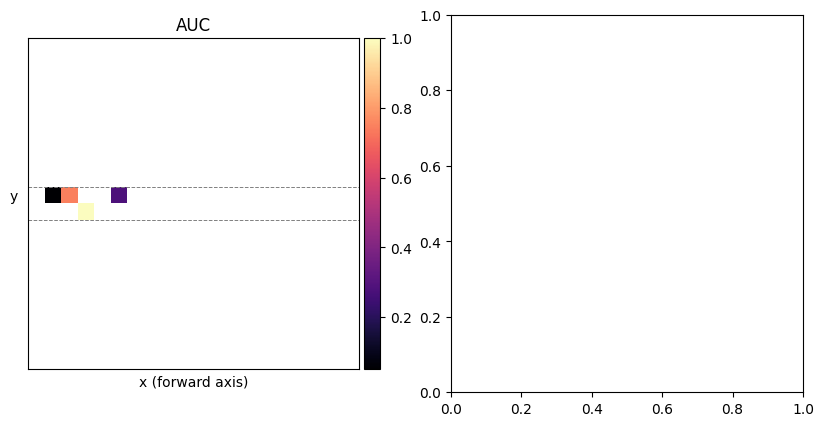

In [325]:
import training
importlib.reload(training)
from training import compute_masks
from sklearn.metrics import roc_auc_score
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Argmax
output = np.vstack(preds)[...,1]

# Desired occupancy map
y = np.array([np.array(x) for x in run_df['target_map'].values])

print(output.shape, y.shape)

cmap = cm.magma

lst = []
for i in range(400):
    val = np.nan
    if len(np.unique(y[:, i])) != 1:
        val = roc_auc_score(y[:, i], output[:, i])
    lst.append(val)
print(np.array(lst).shape)
data = np.array(lst).reshape(20,20)

fig, axs = plt.subplots(1, 2, figsize=(10,5), dpi=100)
ax = axs[0]
im = ax.imshow(data, cmap=cmap)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('x (forward axis)')
ax.set_ylabel('y', rotation=0, labelpad=10)
ax.plot([0, 1], [9 / 20, 9 / 20], linewidth=0.7, linestyle='--', color='grey', transform=ax.transAxes)
ax.plot([0, 1], [11 / 20, 11 / 20], linewidth=0.7, linestyle='--', color='grey', transform=ax.transAxes)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, ax=ax, cax=cax)
ax.set_title('AUC')

# lst = []
# for i in range(400):
#     val = cmap(np.sum(-output[:,i] * np.log(output[:, i] + 1e-10)))
#     lst.append(val)
# print(np.array(lst).shape)
# data = np.array(lst).reshape(20,20,-1)
                     
# ax = axs[1]
# im = ax.imshow(data, cmap=cmap)

# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlabel('x (forward axis)')
# ax.set_ylabel('y', rotation=0, labelpad=10)
# ax.set_title('Entropy')
# ax.plot([0, 1], [9 / 20, 9 / 20], linewidth=0.7, linestyle='--', color='grey', transform=ax.transAxes)
# ax.plot([0, 1], [11 / 20, 11 / 20], linewidth=0.7, linestyle='--', color='grey', transform=ax.transAxes)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(im, ax=ax, cax=cax)
# plt.tight_layout()
plt.show()

In [315]:
display(y.shape)
np.sum(y, axis=0).shape

(16, 400)

(400,)

In [300]:
print(output.shape, y.shape)

# AUC
lst = []
for i in range(400):
    val = np.nan
    if len(np.unique(y[:, i])) != 1:
        val = roc_auc_score(y[:, i], output[:, i])
    lst.append(val)
print('AUC cells:', len(lst), end=', ')
# Entropy
lst = []¢¢
for i in range(400):
    val = np.nan
    if (output[:, i] != 0).all():
        val = np.sum(-output[:,i] * np.log(output[:, i]))
    lst.append(val)
print('Entropy cells:', len(lst))

(16, 400) (16, 400)
AUC cells: 400, Entropy cells: 400


In [301]:
roc_auc_score(y, output)

ValueError: multiclass-multioutput format is not supported

In [148]:
importlib.reload(animator)
from animator import Animator
Animator(run_df, targets, save_path=video_path)
subprocess.call(['/Applications/mpv.app/Contents/MacOS/mpv', video_path]);

Process complete. Video file saved to: /Users/ste/code/active_learning/history/1205-002637/experiments/test/507.mp4


## Junkyard

/usr/local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


(50, 400, 2)

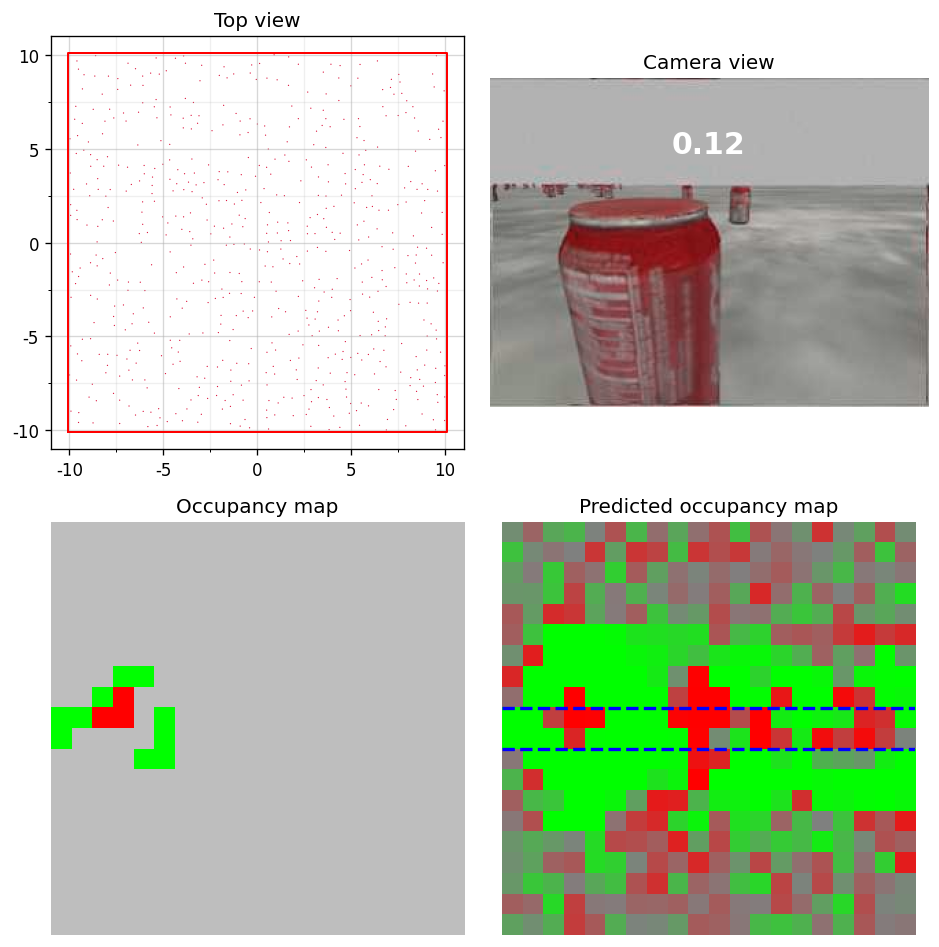

In [51]:
importlib.reload(animator)
run_id = 507
run_df = dataset[dataset['run'] == run_id].iloc[-50:].copy()
model.eval()
with torch.no_grad():
    batches = np.split(run_df, np.arange(batch_size, len(run_df), batch_size))
    preds = [model(torch.stack(x['image'].map(transform).values.tolist())).detach() for x in tqdm(batches)]
    #occ_map = np.argmax(np.vstack(preds), axis=-1)
    display(np.vstack(preds).shape)
    occ_map = np.vstack(preds)[...,-1]
run_df['predicted_map'] = pd.Series(occ_map.tolist(), index=run_df.index)
video_path = os.path.join(path, f'{run_id}.mp4')
animator.Animator(run_df, targets)

'/Users/ste/code/active_learning/history/1205-002637/experiments/tests/104.mp4'

In [120]:
from IPython.display import Video

video_path = os.path.join(d_path,"experiments/104.mp4")
Video(video_path)

ValueError: To embed videos, you must pass embed=True (this may make your notebook files huge)
Consider passing Video(url='...')

In [119]:
d_path

'/Users/ste/code/active_learning/history/1205-002637/'

In [101]:
import analyzer, importlib
importlib.reload(analyzer)

from IPython.display import Video
video_path = os.path.join(d_path,'experiments','time_green-panda','run_id.mp4')
analyzer.Animator(check, targets, save_path=video_path);
Video(video_path)

/usr/local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Process complete. Video file saved to: /Users/ste/code/active_learning/history/1205-002637/experiments/time_green-panda/run_id.mp4


In [86]:
model

ConvNet(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, 